<a href="https://colab.research.google.com/github/ektamistry/Denoising-Images-/blob/main/GANs_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r test.zip /content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV

  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/ (stored 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/ (stored 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/0007.png (deflated 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/0006.png (deflated 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/0004.png (deflated 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/0003.png (deflated 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/0001.png (deflated 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/0002.png (deflated 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/0005.png (deflated 0%)
  adding: content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR/0009.png (deflated 0%)
  adding: content/drive/MyDrive/ATML_CV/gaus

In [ ]:
import cv2
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Input, Conv2DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

# Load


In [ ]:
import os
import cv2
import numpy as np

image_train_dir = "/content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_train_HR"
image_test_dir = "/content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_test_HR"
image_val_dir = "/content/drive/MyDrive/ATML_CV/gaussian/data_ATML_CV/DIV2K_valid_HR"

# Define a target directory where you want to save the processed images
output_train_dir = "/content/images/train"
output_val_dir = "/content/images/val"
output_test_dir = "/content/images/test"


target_size = (256, 256)

# Function to load and process images and save them
def load_process_save_images(input_dir, output_dir):
    image_list = []
    for filename in os.listdir(input_dir):
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        image_list.append(image)

        # Save the processed image to the output directory
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

    return np.array(image_list)

# Process and save training images
image_train = load_process_save_images(image_train_dir, output_train_dir)

# Process and save validation images
image_val = load_process_save_images(image_val_dir, output_val_dir)

# Process and save testing images
image_test = load_process_save_images(image_test_dir, output_test_dir)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images ( a, b ):
  n=3
  for i in range(3):
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(a[i])
      plt.axis('off')

      # Noisy image
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(b[i])
      plt.axis('off')

  # Adjust spacing between subplots
  plt.tight_layout()
  plt.show()
  #195075

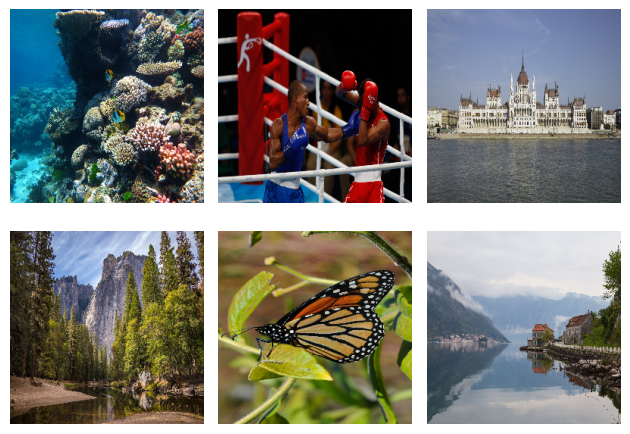

In [ ]:
plot_images(image_train, image_test)

# Adding Gaussian Noise

In [ ]:
# adding Gaussian Noise
mean = 0.0
std = 0.25

noisy_train = []
noisy_test = []
noisy_val = []

def gaussian(mean, std, image):
      noise = np.random.normal(mean, std, image.shape).astype(np.float32)
      noisy_image = cv2.add(image, noise)
      return(noisy_image)

# for train
for image in image_train:
    noisy_image = gaussian(mean, std, image)
    noisy_train.append(noisy_image)

# for val
for image in image_val:
    noisy_image = gaussian(mean, std, image)
    noisy_val.append(noisy_image)

# for test
for image in image_test:
    noisy_image = gaussian(mean, std, image)
    noisy_test.append(noisy_image)


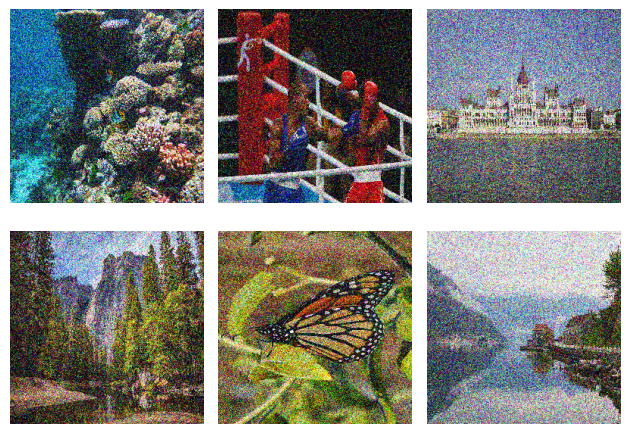

In [ ]:
plot_images(noisy_train, noisy_test)

In [ ]:
noisy_train = np.array(noisy_train)
image_train = np.array(image_train)
noisy_test = np.array(noisy_test)
image_test = np.array(image_test)
noisy_val = np.array(noisy_val)
image_val = np.array(image_val)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Conv2DTranspose
from tensorflow.keras.models import Model

# Define your input shape
input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape)

# Encoder Layers
x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Decoder Layers
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Output layer
output_layer = Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='sigmoid', input_shape=(256, 256, 3))(x)
#output_layer = Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='sigmoid', input_shape=(256, 256, 3))(x)

generator = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the generator with msr
generator.compile(optimizer='adam', loss='mean_squared_error')
generator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                            

In [ ]:
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense

# Define the input shape for the discriminator (same as the output shape of your generator)
discriminator_input = Input(shape=input_shape)

# Encoder layers
x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(discriminator_input)
x = LeakyReLU(0.2)(x)

x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

# Flatten the output and add a dense layer for binary classification
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(inputs=discriminator_input, outputs=x)

# Compile the discriminator with binary cross-entropy loss
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_7 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                           

In [ ]:
from keras.applications import VGG19
from keras.models import Model

input_shape = (256, 256, 3)

def vgg_19(input_shape, layer_index):
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    layer = vgg.layers[layer_index]
    return Model(inputs=vgg.inputs, outputs=layer.output)


layer = 20
vgg = vgg_19(input_shape, layer)
vgg.trainable = False
vgg.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                            

In [ ]:
def create_comb(generator, discriminator, vgg, input_shape):
    noisy_input = Input(shape=input_shape)
    image_input = Input(shape=input_shape)

    generated_images = generator(noisy_input)
    generated_features = vgg(generated_images)

    discriminator.trainable = False
    validity = discriminator(generated_images)

    return Model(inputs=[noisy_input, image_input], outputs=[validity, generated_features])

# Define input shape
input_shape = (256, 256, 3)

# Create the combined GANs model
gans_model = create_comb(generator, discriminator, vgg, input_shape)

# Compile the GANs model
gans_model.compile(loss=["binary_crossentropy", "mean_squared_error"], loss_weights=[1e-3, 1], optimizer="adam")

# Summary of the combined GANs model
gans_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 256, 256, 3)          3107075   ['input_4[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    1685633   ['model[0][0]']               
                                                                                            

In [ ]:
batch_size = 32
noisy_train_batches = []
images_train_batches = []
for it in range(int(image_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    images_train_batches.append(image_train[start_idx:end_idx])
    noisy_train_batches.append(noisy_train[start_idx:end_idx])


In [ ]:
epochs = 16
from tqdm import tqdm

for e in range(epochs):
  fake_label = np.zeros((batch_size,1))
  real_label = np.ones((batch_size,1))

  g_losses = []
  d_losses = []

  for b in tqdm(range(len(images_train_batches))):
    nosiy_imgs = noisy_train_batches[b]
    clear_imgs = images_train_batches[b]

    fake_imgs = generator.predict_on_batch(nosiy_imgs)

    # training discriminator on fake and real clear image
    discriminator.trainable = True
    d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
    d_loss_real = discriminator.train_on_batch(clear_imgs, real_label)

    discriminator.trainable = False

    d_loss = 0.5*np.add(d_loss_gen, d_loss_real) #avg

    image_features = vgg.predict(clear_imgs)

    g_loss = gans_model.train_on_batch([nosiy_imgs,clear_imgs], [real_label,image_features])

    d_losses.append(d_loss)
    g_losses.append(g_loss)

  d_losses = np.array(d_losses)
  g_losses = np.array(g_losses)

  d_loss = np.sum(d_losses, axis=0) / len(d_losses)
  g_loss = np.sum(g_losses, axis=0) / len(g_losses)

  print("epoch:", e, "generator loss:", g_loss, "discriminator loss:", d_loss)

  if (e+1)%10 == 0:
    generator.save("gen_e"+str(e+1)+".h5")


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  5%|▍         | 1/21 [00:41<13:46, 41.31s/it]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 2/21 [00:42<05:38, 17.84s/it]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 3/21 [00:44<03:05, 10.32s/it]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 4/21 [00:45<01:56,  6.83s/it]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 5/21 [00:47<01:19,  4.94s/it]

1/1 [==============================] - 0s 58ms/step


 29%|██▊       | 6/21 [00:48<00:57,  3.81s/it]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 7/21 [00:51<00:46,  3.31s/it]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8/21 [00:52<00:34,  2.69s/it]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 9/21 [00:53<00:27,  2.29s/it]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 10/21 [00:55<00:22,  2.02s/it]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11/21 [00:56<00:18,  1.84s/it]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 12/21 [00:58<00:15,  1.75s/it]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 13/21 [00:59<00:13,  1.66s/it]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 14/21 [01:01<00:11,  1.62s/it]

1/1 [==============================] - 0s 122ms/step


 71%|███████▏  | 15/21 [01:03<00:11,  1.94s/it]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 16/21 [01:05<00:09,  1.83s/it]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 17/21 [01:06<00:06,  1.67s/it]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18/21 [01:08<00:04,  1.59s/it]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 19/21 [01:09<00:03,  1.51s/it]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20/21 [01:10<00:01,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 21/21 [01:12<00:00,  3.44s/it]


epoch: 0 generator loss: [0.06222895 0.00089301 0.06222806] discriminator loss: [0.17292909 0.97991071]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1/21 [00:01<00:30,  1.50s/it]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2/21 [00:02<00:28,  1.49s/it]

1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 3/21 [00:04<00:27,  1.54s/it]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 4/21 [00:06<00:26,  1.57s/it]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 5/21 [00:07<00:23,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 6/21 [00:08<00:21,  1.45s/it]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 7/21 [00:10<00:20,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8/21 [00:11<00:18,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9/21 [00:13<00:17,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10/21 [00:14<00:15,  1.45s/it]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11/21 [00:16<00:16,  1.68s/it]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 12/21 [00:19<00:16,  1.85s/it]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 13/21 [00:20<00:13,  1.73s/it]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 14/21 [00:21<00:11,  1.61s/it]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 15/21 [00:23<00:09,  1.55s/it]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16/21 [00:24<00:07,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 17/21 [00:26<00:05,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18/21 [00:27<00:04,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 19/21 [00:28<00:02,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 20/21 [00:30<00:01,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


epoch: 1 generator loss: [5.60863795e-02 6.63783546e-13 5.60863795e-02] discriminator loss: [8.42618448e-12 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1/21 [00:01<00:28,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 2/21 [00:02<00:26,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 3/21 [00:04<00:25,  1.44s/it]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 4/21 [00:05<00:24,  1.44s/it]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5/21 [00:07<00:22,  1.42s/it]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 6/21 [00:08<00:21,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 7/21 [00:10<00:20,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 8/21 [00:11<00:19,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 9/21 [00:13<00:17,  1.49s/it]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 10/21 [00:15<00:20,  1.86s/it]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 11/21 [00:17<00:17,  1.78s/it]

1/1 [==============================] - 0s 71ms/step


 57%|█████▋    | 12/21 [00:19<00:17,  1.98s/it]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13/21 [00:21<00:14,  1.85s/it]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14/21 [00:22<00:11,  1.70s/it]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 15/21 [00:24<00:10,  1.83s/it]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 16/21 [00:26<00:08,  1.74s/it]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17/21 [00:27<00:06,  1.62s/it]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 18/21 [00:29<00:04,  1.59s/it]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19/21 [00:30<00:03,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 20/21 [00:32<00:01,  1.49s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 21/21 [00:33<00:00,  1.59s/it]


epoch: 2 generator loss: [5.37917580e-02 8.48108956e-12 5.37917580e-02] discriminator loss: [1.50033366e-04 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1/21 [00:02<00:40,  2.02s/it]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 2/21 [00:03<00:37,  1.96s/it]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 3/21 [00:06<00:36,  2.03s/it]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 4/21 [00:07<00:30,  1.78s/it]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 5/21 [00:08<00:25,  1.61s/it]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6/21 [00:10<00:22,  1.51s/it]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7/21 [00:11<00:20,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8/21 [00:12<00:18,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9/21 [00:14<00:16,  1.41s/it]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10/21 [00:15<00:15,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 11/21 [00:17<00:14,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 12/21 [00:18<00:13,  1.49s/it]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 13/21 [00:20<00:11,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 14/21 [00:21<00:10,  1.45s/it]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 15/21 [00:22<00:08,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 16/21 [00:24<00:07,  1.45s/it]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 17/21 [00:25<00:05,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 18/21 [00:27<00:04,  1.39s/it]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 19/21 [00:28<00:02,  1.40s/it]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20/21 [00:29<00:01,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


epoch: 3 generator loss: [5.23117215e-02 4.36202803e-15 5.23117215e-02] discriminator loss: [5.816228e-17 1.000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1/21 [00:01<00:26,  1.33s/it]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 2/21 [00:02<00:25,  1.37s/it]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 3/21 [00:04<00:24,  1.37s/it]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 4/21 [00:05<00:24,  1.43s/it]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 5/21 [00:06<00:22,  1.41s/it]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6/21 [00:08<00:20,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 7/21 [00:09<00:19,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 8/21 [00:11<00:21,  1.63s/it]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 9/21 [00:13<00:19,  1.61s/it]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10/21 [00:14<00:16,  1.52s/it]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 11/21 [00:16<00:14,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12/21 [00:17<00:13,  1.45s/it]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 13/21 [00:18<00:11,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14/21 [00:20<00:09,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 15/21 [00:21<00:08,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 16/21 [00:23<00:08,  1.60s/it]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 17/21 [00:25<00:06,  1.63s/it]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 18/21 [00:27<00:04,  1.61s/it]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 19/21 [00:28<00:03,  1.51s/it]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 20/21 [00:29<00:01,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 21/21 [00:30<00:00,  1.47s/it]


epoch: 4 generator loss: [5.05417153e-02 6.12725141e-20 5.05417153e-02] discriminator loss: [7.04220551e-17 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1/21 [00:01<00:26,  1.31s/it]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2/21 [00:02<00:25,  1.35s/it]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 3/21 [00:04<00:24,  1.35s/it]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 4/21 [00:05<00:22,  1.35s/it]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 5/21 [00:07<00:26,  1.67s/it]

1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 6/21 [00:09<00:23,  1.58s/it]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7/21 [00:10<00:20,  1.49s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8/21 [00:11<00:18,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9/21 [00:13<00:17,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10/21 [00:14<00:15,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 11/21 [00:16<00:14,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12/21 [00:17<00:13,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 13/21 [00:19<00:13,  1.65s/it]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 14/21 [00:21<00:12,  1.82s/it]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 15/21 [00:23<00:10,  1.67s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 16/21 [00:24<00:07,  1.56s/it]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17/21 [00:25<00:05,  1.50s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 18/21 [00:27<00:04,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 19/21 [00:28<00:02,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20/21 [00:30<00:01,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


epoch: 5 generator loss: [4.85243700e-02 4.89475738e-22 4.85243700e-02] discriminator loss: [7.05958085e-17 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 1/21 [00:02<00:45,  2.26s/it]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2/21 [00:03<00:34,  1.80s/it]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 3/21 [00:05<00:28,  1.60s/it]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4/21 [00:06<00:25,  1.48s/it]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5/21 [00:07<00:23,  1.46s/it]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6/21 [00:09<00:21,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 7/21 [00:10<00:19,  1.41s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8/21 [00:12<00:18,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 9/21 [00:14<00:20,  1.71s/it]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 10/21 [00:16<00:19,  1.74s/it]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 11/21 [00:17<00:16,  1.66s/it]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 12/21 [00:19<00:14,  1.59s/it]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 13/21 [00:20<00:12,  1.54s/it]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 14/21 [00:21<00:10,  1.47s/it]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 15/21 [00:23<00:08,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 16/21 [00:24<00:07,  1.42s/it]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 17/21 [00:26<00:06,  1.62s/it]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 18/21 [00:28<00:04,  1.60s/it]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 19/21 [00:29<00:03,  1.60s/it]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20/21 [00:31<00:01,  1.54s/it]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 21/21 [00:32<00:00,  1.56s/it]


epoch: 6 generator loss: [4.60765773e-02 6.56047072e-23 4.60765773e-02] discriminator loss: [7.05963479e-17 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1/21 [00:01<00:29,  1.46s/it]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2/21 [00:02<00:27,  1.46s/it]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 3/21 [00:04<00:25,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 4/21 [00:06<00:28,  1.66s/it]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 5/21 [00:08<00:29,  1.87s/it]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 6/21 [00:09<00:25,  1.71s/it]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7/21 [00:11<00:22,  1.62s/it]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8/21 [00:12<00:20,  1.56s/it]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 9/21 [00:14<00:18,  1.51s/it]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10/21 [00:15<00:16,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11/21 [00:17<00:14,  1.48s/it]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 12/21 [00:19<00:14,  1.61s/it]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 13/21 [00:21<00:14,  1.77s/it]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 14/21 [00:22<00:11,  1.63s/it]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 15/21 [00:23<00:09,  1.56s/it]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 16/21 [00:25<00:07,  1.52s/it]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 17/21 [00:26<00:05,  1.50s/it]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18/21 [00:28<00:04,  1.49s/it]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 19/21 [00:29<00:02,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 20/21 [00:31<00:01,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 21/21 [00:32<00:00,  1.56s/it]


epoch: 7 generator loss: [4.42001454e-02 1.04862944e-23 4.42001454e-02] discriminator loss: [7.05963479e-17 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 1/21 [00:01<00:30,  1.51s/it]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2/21 [00:02<00:27,  1.45s/it]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 3/21 [00:04<00:26,  1.45s/it]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4/21 [00:05<00:23,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 5/21 [00:07<00:22,  1.39s/it]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6/21 [00:08<00:20,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7/21 [00:09<00:19,  1.40s/it]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8/21 [00:11<00:18,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 9/21 [00:13<00:19,  1.64s/it]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 10/21 [00:15<00:18,  1.64s/it]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11/21 [00:16<00:15,  1.57s/it]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12/21 [00:17<00:13,  1.49s/it]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 13/21 [00:19<00:11,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 14/21 [00:20<00:10,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 15/21 [00:22<00:08,  1.43s/it]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16/21 [00:23<00:07,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 17/21 [00:24<00:05,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 18/21 [00:27<00:05,  1.69s/it]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 19/21 [00:28<00:03,  1.64s/it]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20/21 [00:30<00:01,  1.54s/it]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


epoch: 8 generator loss: [4.28687320e-02 2.59239948e-24 4.28687320e-02] discriminator loss: [3.81820225e-12 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 1/21 [00:01<00:26,  1.33s/it]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2/21 [00:03<00:33,  1.74s/it]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 3/21 [00:04<00:27,  1.56s/it]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 4/21 [00:06<00:30,  1.77s/it]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 5/21 [00:09<00:31,  1.95s/it]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6/21 [00:10<00:26,  1.79s/it]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7/21 [00:11<00:23,  1.66s/it]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8/21 [00:13<00:20,  1.59s/it]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9/21 [00:14<00:18,  1.51s/it]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10/21 [00:16<00:15,  1.45s/it]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11/21 [00:17<00:14,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 12/21 [00:18<00:12,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 13/21 [00:20<00:11,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 14/21 [00:22<00:11,  1.64s/it]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 15/21 [00:23<00:09,  1.57s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 16/21 [00:25<00:07,  1.58s/it]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17/21 [00:26<00:06,  1.52s/it]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18/21 [00:28<00:04,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 19/21 [00:29<00:02,  1.45s/it]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 20/21 [00:30<00:01,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 21/21 [00:32<00:00,  1.53s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch: 9 generator loss: [0.04951596 7.35568752 0.04216027] discriminator loss: [0.1594536  0.99181548]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 1/21 [00:01<00:31,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 10%|▉         | 2/21 [00:03<00:29,  1.57s/it]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 3/21 [00:04<00:27,  1.52s/it]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4/21 [00:06<00:25,  1.48s/it]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5/21 [00:07<00:23,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 29%|██▊       | 6/21 [00:09<00:26,  1.76s/it]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 7/21 [00:11<00:22,  1.62s/it]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8/21 [00:12<00:20,  1.54s/it]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 9/21 [00:14<00:20,  1.67s/it]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 10/21 [00:16<00:19,  1.77s/it]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 11/21 [00:17<00:16,  1.69s/it]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 12/21 [00:19<00:14,  1.60s/it]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 13/21 [00:20<00:12,  1.56s/it]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14/21 [00:22<00:10,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 15/21 [00:23<00:08,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 16/21 [00:25<00:08,  1.62s/it]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17/21 [00:26<00:06,  1.53s/it]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 18/21 [00:28<00:04,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 19/21 [00:30<00:03,  1.57s/it]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 20/21 [00:31<00:01,  1.49s/it]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 21/21 [00:32<00:00,  1.56s/it]


epoch: 10 generator loss: [0.04679486 0.         0.04679486] discriminator loss: [0.0461715  0.99702381]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1/21 [00:01<00:30,  1.52s/it]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 2/21 [00:02<00:26,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 3/21 [00:04<00:29,  1.63s/it]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 4/21 [00:06<00:26,  1.53s/it]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5/21 [00:08<00:27,  1.70s/it]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 6/21 [00:09<00:24,  1.64s/it]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 7/21 [00:11<00:21,  1.56s/it]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8/21 [00:12<00:19,  1.49s/it]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9/21 [00:13<00:17,  1.49s/it]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10/21 [00:15<00:16,  1.49s/it]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 11/21 [00:16<00:14,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12/21 [00:18<00:13,  1.45s/it]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 13/21 [00:19<00:11,  1.41s/it]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 14/21 [00:20<00:09,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 15/21 [00:23<00:10,  1.67s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 16/21 [00:24<00:07,  1.56s/it]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 17/21 [00:25<00:05,  1.48s/it]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18/21 [00:27<00:04,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 19/21 [00:28<00:02,  1.41s/it]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 20/21 [00:29<00:01,  1.38s/it]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 21/21 [00:31<00:00,  1.49s/it]


epoch: 11 generator loss: [4.15291272e-02 1.13164532e-11 4.15291272e-02] discriminator loss: [2.75645942e-29 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1/21 [00:01<00:28,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 2/21 [00:03<00:34,  1.84s/it]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 3/21 [00:05<00:31,  1.75s/it]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4/21 [00:06<00:26,  1.58s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 5/21 [00:07<00:23,  1.49s/it]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6/21 [00:09<00:21,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7/21 [00:10<00:19,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8/21 [00:11<00:18,  1.42s/it]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9/21 [00:13<00:19,  1.60s/it]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10/21 [00:15<00:17,  1.58s/it]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 11/21 [00:17<00:15,  1.60s/it]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 12/21 [00:18<00:13,  1.54s/it]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 13/21 [00:19<00:11,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 14/21 [00:21<00:10,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 15/21 [00:22<00:08,  1.40s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 16/21 [00:24<00:07,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 17/21 [00:25<00:05,  1.42s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 18/21 [00:26<00:04,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 19/21 [00:29<00:03,  1.68s/it]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20/21 [00:30<00:01,  1.58s/it]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 21/21 [00:31<00:00,  1.51s/it]


epoch: 12 generator loss: [3.86811200e-02 4.18666552e-08 3.86811200e-02] discriminator loss: [1.38475531e-28 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1/21 [00:01<00:26,  1.30s/it]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 2/21 [00:02<00:24,  1.31s/it]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 3/21 [00:03<00:23,  1.31s/it]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 4/21 [00:05<00:22,  1.35s/it]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5/21 [00:06<00:21,  1.34s/it]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 6/21 [00:08<00:23,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 7/21 [00:10<00:22,  1.57s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8/21 [00:11<00:19,  1.51s/it]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9/21 [00:12<00:17,  1.45s/it]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10/21 [00:14<00:15,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11/21 [00:15<00:14,  1.41s/it]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12/21 [00:17<00:12,  1.40s/it]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13/21 [00:18<00:11,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 14/21 [00:19<00:09,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 15/21 [00:22<00:09,  1.64s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 16/21 [00:23<00:07,  1.59s/it]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 17/21 [00:24<00:06,  1.53s/it]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18/21 [00:26<00:04,  1.48s/it]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 19/21 [00:27<00:02,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 20/21 [00:28<00:01,  1.40s/it]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 21/21 [00:30<00:00,  1.44s/it]


epoch: 13 generator loss: [3.69976667e-02 1.69694439e-05 3.69976500e-02] discriminator loss: [1.52877292e-28 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1/21 [00:01<00:27,  1.37s/it]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2/21 [00:03<00:32,  1.69s/it]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 3/21 [00:04<00:30,  1.67s/it]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4/21 [00:06<00:26,  1.54s/it]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5/21 [00:07<00:24,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 6/21 [00:09<00:22,  1.50s/it]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7/21 [00:10<00:20,  1.47s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8/21 [00:11<00:18,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 9/21 [00:13<00:17,  1.42s/it]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10/21 [00:14<00:15,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 11/21 [00:16<00:13,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 12/21 [00:17<00:12,  1.43s/it]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 13/21 [00:19<00:11,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14/21 [00:20<00:09,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 15/21 [00:21<00:08,  1.45s/it]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16/21 [00:23<00:07,  1.45s/it]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17/21 [00:24<00:05,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18/21 [00:26<00:04,  1.39s/it]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 19/21 [00:28<00:03,  1.58s/it]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 20/21 [00:29<00:01,  1.57s/it]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 21/21 [00:31<00:00,  1.48s/it]


epoch: 14 generator loss: [0.03540628 0.00275659 0.03540352] discriminator loss: [1.53065135e-28 1.00000000e+00]


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1/21 [00:01<00:30,  1.51s/it]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2/21 [00:02<00:27,  1.44s/it]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 3/21 [00:04<00:25,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4/21 [00:05<00:24,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 5/21 [00:07<00:22,  1.44s/it]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 6/21 [00:09<00:24,  1.62s/it]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 7/21 [00:10<00:22,  1.58s/it]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 8/21 [00:11<00:19,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9/21 [00:13<00:17,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10/21 [00:14<00:15,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 11/21 [00:15<00:13,  1.36s/it]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 12/21 [00:17<00:12,  1.34s/it]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 13/21 [00:18<00:10,  1.33s/it]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 14/21 [00:19<00:09,  1.33s/it]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 15/21 [00:21<00:09,  1.57s/it]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 16/21 [00:23<00:07,  1.57s/it]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 17/21 [00:24<00:05,  1.49s/it]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18/21 [00:26<00:04,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 19/21 [00:27<00:02,  1.42s/it]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 20/21 [00:28<00:01,  1.38s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 21/21 [00:30<00:00,  1.44s/it]

epoch: 15 generator loss: [0.03375785 0.00012229 0.03375772] discriminator loss: [1.53065135e-28 1.00000000e+00]


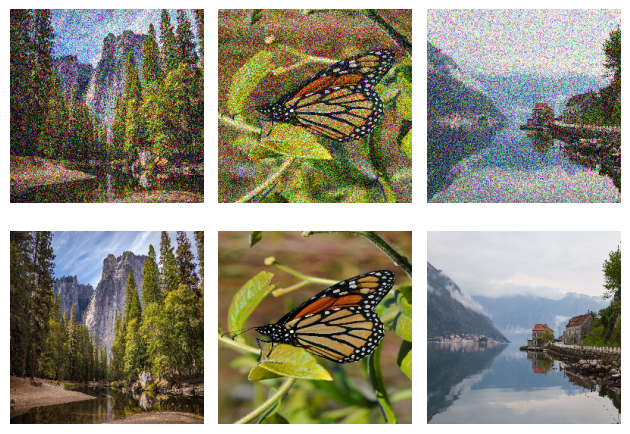

In [ ]:
plot_images(noisy_test, image_test)

In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/gen_e110.h5', compile=False)



1/1 [==============================] - 0s 19ms/step


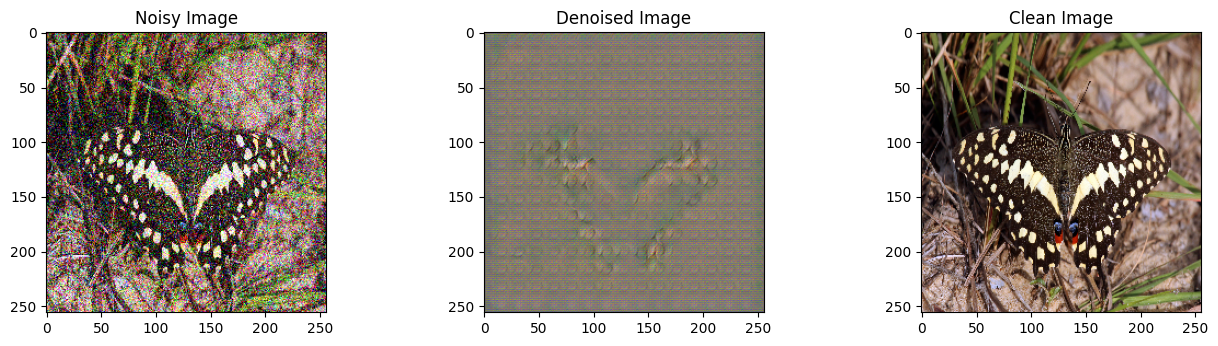

In [ ]:

[X1, X2] = [noisy_test[:20], image_test[:20]]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Noisy Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Denoised Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Clean Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 0s 30ms/step


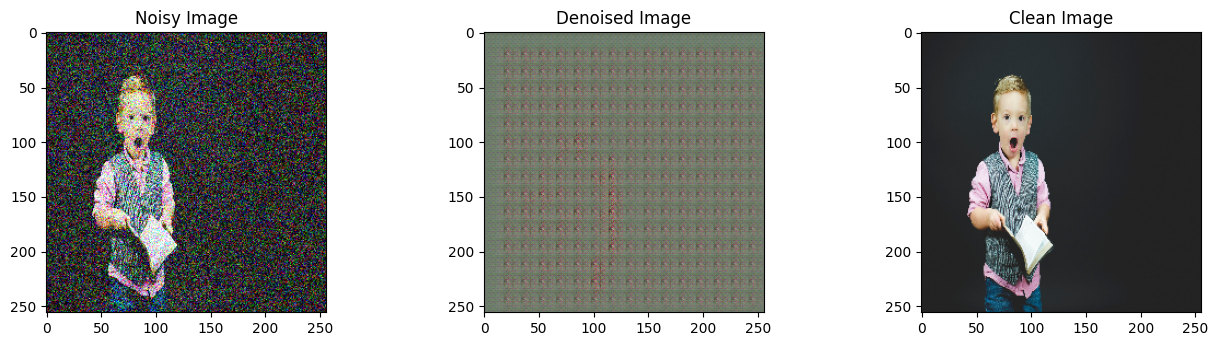

In [ ]:

[X1, X2] = [noisy_test[:20], image_test[:20]]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Noisy Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Denoised Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Clean Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 0s 34ms/step


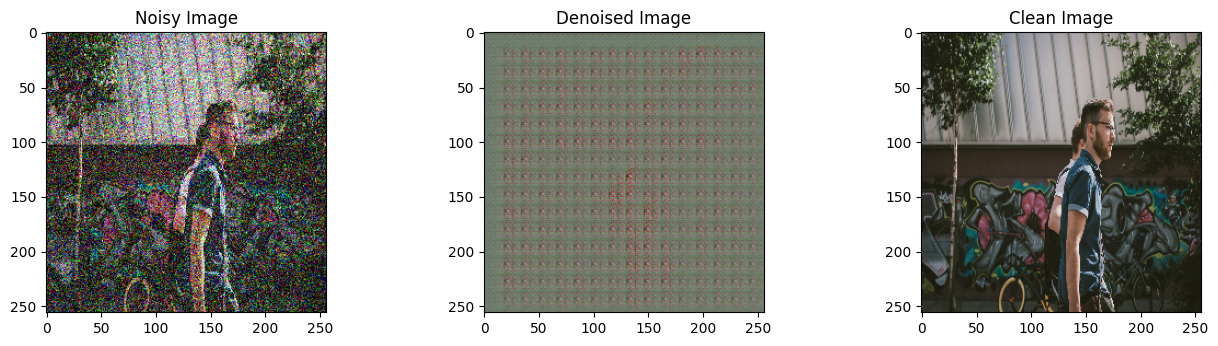

In [ ]:

[X1, X2] = [noisy_test[:20], image_test[:20]]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Noisy Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Denoised Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Clean Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 0s 88ms/step


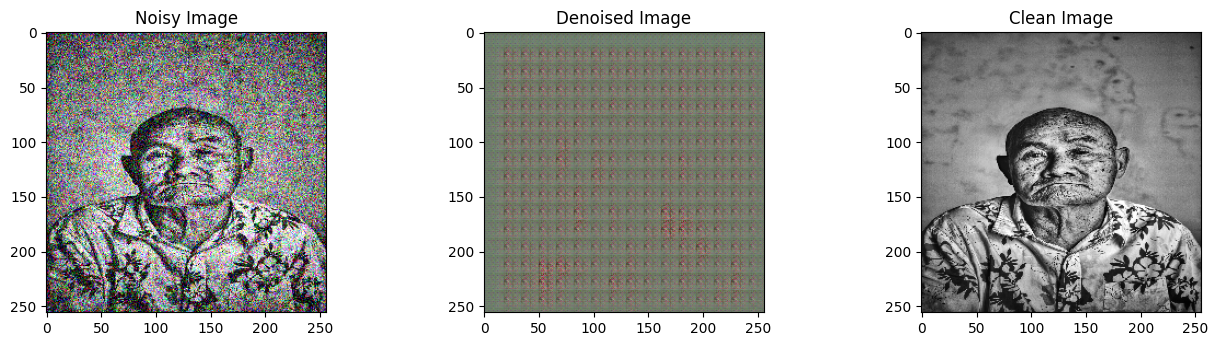

In [ ]:

[X1, X2] = [noisy_test[:20], image_test[:20]]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Noisy Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Denoised Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Clean Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 0s 32ms/step


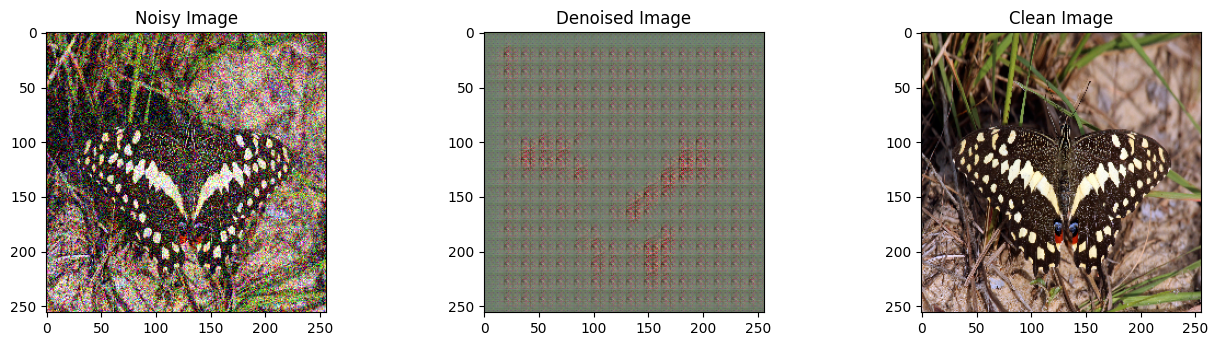

In [ ]:

[X1, X2] = [noisy_test[:20], image_test[:20]]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Noisy Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Denoised Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Clean Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 0s 33ms/step


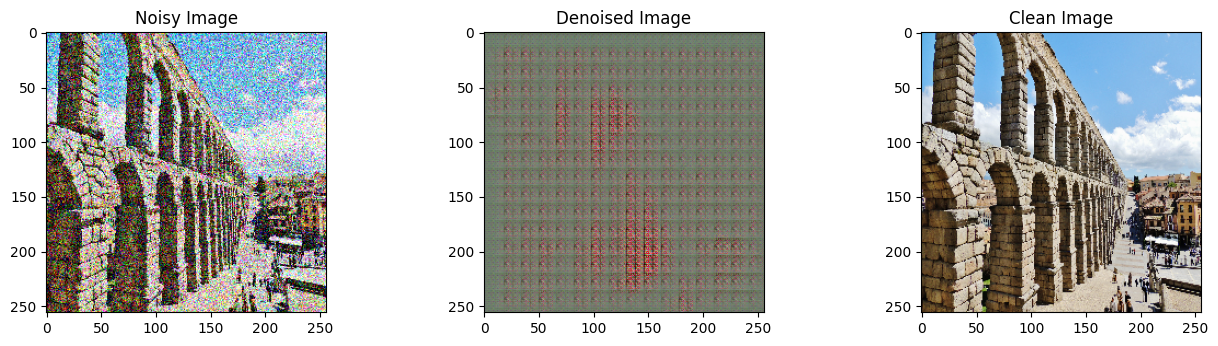

In [ ]:

[X1, X2] = [noisy_test[:20], image_test[:20]]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Noisy Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Denoised Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Clean Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 0s 22ms/step


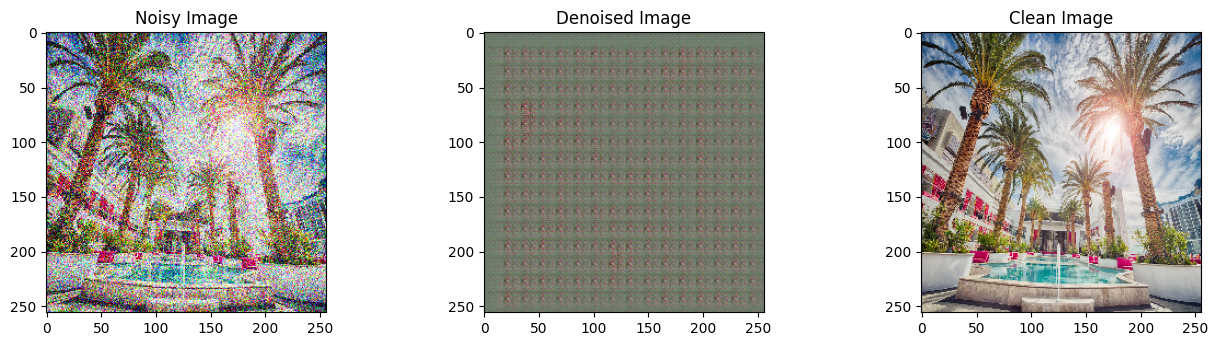

In [ ]:

[X1, X2] = [noisy_test[:20], image_test[:20]]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Noisy Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Denoised Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Clean Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 0s 22ms/step


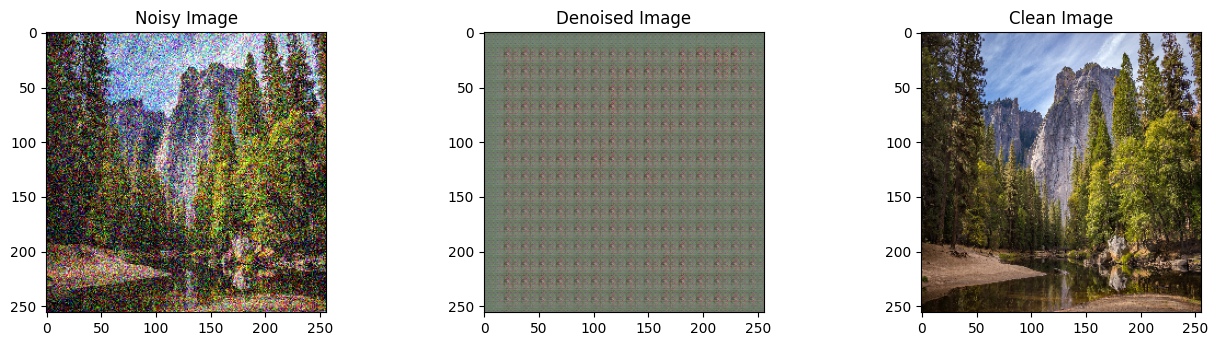

In [ ]:

[X1, X2] = [noisy_test[:20], image_test[:20]]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Noisy Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Denoised Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Clean Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
